# 智能制造的准实时分析
```text
                刘定强 2022.04.06
```
[Click here for English version](RealtimeAnalyticsOnSemistructureData_en.ipynb) 

总结一下近期服务一些制造业客户后对智能制造分析业务场景的新认识。

现在相当多的现代制造企业已经有了一定智能水平的自动化辅助制造设备，生产过程已经实现了信息化，每个工厂每天都会在制造执行系统产生详细的过程数据。制造企业大多都希望能准实时地采集、处理和整合生产、质量、事件等方面的数据，以看板、大屏幕和报表等多种方式分析生产过程的效率瓶颈、各个检测环节良率变化，以促进生产过程改进、提高生产效能和产品良率并降低耗损和生产成本，从而提升产品和企业的竞争力。

然而规模化的制造企业往往有不少分布在不同地理位置的工厂，而且除了制造执行系统中的结构化数据外，还有大量的智能设备传感器数据或者系统埋点数据。这些整合起来困难重重，尤其是要实现准实时的数据整合和分析。

一方面，这些分析业务大多从围绕制造执行系统开始，而且很多企业的分析业务一开始甚至就运行在制造执行系统的同一个数据库中。这些数据库往往是 SQLServer 或 PostgreSQL 这样的传统交易数据库，本来就不太擅长分析业务，更不用说性能要求更高的半结构化的传感器或埋点数据了。就算采用数据库复制技术把分析业务分离出来，也支撑不了大量数据处理和分析的性能要求。

另一方面，受前些年“大数据就是Hadoop”的影响，企业投入了不少资金建设的基于Hadoop的大数据系统，最后却发现其分析性能和并发能力完全无法满足企业级的需求，时效性更无法谈起。

从一开始就专注于大数据实时分析的 Vertica 轻松地解决了制造业用户面临的上述难题。

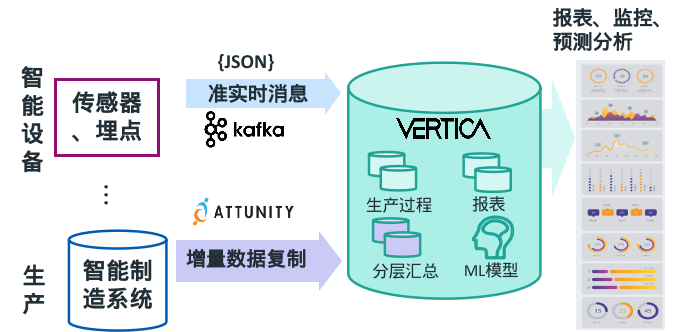

对于制造执行系统存放在关系数据库里的数据，使用 Attunity 或 Informatica 等 CDC（Change Data Capture，变化数据捕获）工具，可以准实时地把变化数据复制到 Vertica 中。以 Vertica 大规模并行计算和列式存储架构的能力，数据进入 Vertica 时可以同时完成宽表的自动加工、同一份数据按多种方式为不同类型的分析查询性能有序压缩存储，甚至是实时聚合存储，从而提供准实时的分析能力。相较于传统数据库，通常有**10~100倍以上的性能提升**。

在此基础上，Vertica 内置的库内机器学习能力，可以在已有的全方位数据上为不同目训练出的各种机器学习模型。在实时数据进入 Vertica 后，就可以基于这些模型进行准确的分析预测。这一切都是基于 SQL 实现的，所以能执行 SQL 的各种可视化工具或应用都能以多种方式呈现这些分析结果，对业务做出快速响应。

而对于海量的半结构化的智能设备传感器数据或者系统埋点数据，只需要把它们送到 Kafka 分布式消息引擎，Vertica 原生的 Kafka 连接器会自动把这些消息从 Kafka 准实时地送入 Vertica。而 Vertica 专为 JSON、CEF 日志等半结构数据的按读时模式(Schema on Read)快速加载和分析场景设计的弹性表([Flex Table](https://www.vertica.com/docs/latest/HTML/Content/Authoring/FlexTables/FlexTableHandbook.htm))，不需要预先严格定义表结构，可以直接加载半结构化数据，分析者不需要提前进行数据处理就可以直接用 SQL 在弹性表上按自己的思路进行灵活的交互式分析乃至预测分析。

本文的后面部分，将展示如何轻松地准实时加载 JSON 半结构化数据，为极速的分析性能要求优化数据存储，以及用库内机器学习进行模型训练和预测分析。

## 1. 准备工作

### 1.1 准备运行环境

我们首先检查和安装相关的包。其中 matplotlib 是用于绘制图形的包， [**nbmultitask**](https://github.com/micahscopes/nbmultitask/) 是为了方便在 Jupyter Notebook 里执行并行任务的包。[**VerticaPy**](https://www.vertica.com/python/) 用来在 Vertica 中执行查询并在 Jupyter Notebook 中展示数据。不仅仅如此，VerticaPy 还能为数据科学家以 Python 接口的方式提供 Vertica 可扩展性能的库内机器学习功能。

In [1]:
%%!
# make sure that verticapy matplotlib nbmultitask are installed
test 3 -eq \
    $(grep -wE "verticapy\s|matplotlib\s|nbmultitask\s" \
          <<< "$(python3 -m pip list)" | wc -l) \
    || python3 -m pip install -qU verticapy matplotlib nbmultitask \
    || echo "Please manually run: \
           python3 -m pip install -qU verticapy matplotlib nbmultitask"

[]

然后设置访问数据库的连接属性。请注意根据您的实际情况更新相关属性值。

In [2]:
from verticapy.connect import *

# Set the primary auto-connection
conn_info = {"host": "localhost", 
             "port": "5433", 
             "database": "testdb", 
             "user": "dbadmin",
             "password": "youPassword"
             }
new_auto_connection(conn_info, name = "VerticaDSN")
change_auto_connection("VerticaDSN")

# load SqlMagic extension
%reload_ext verticapy.sql
print(verticapy.__version__)

0.8.1


,AbcVarchar(128)
1,

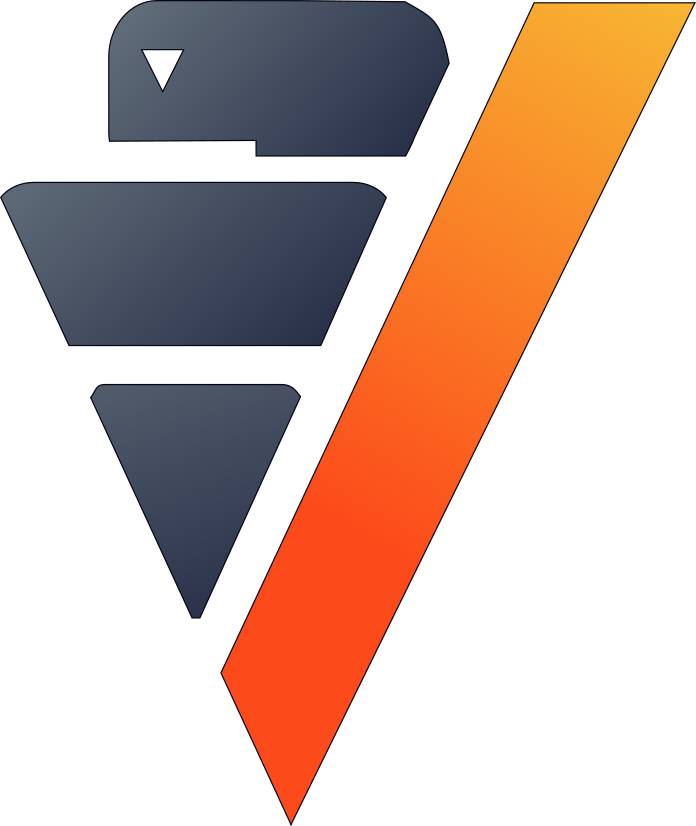

In [3]:
%sql select version();

### 1.2 创建读时模式的弹性表

Vertica 的弹性表([Flex Table](https://www.vertica.com/docs/latest/HTML/Content/Authoring/FlexTables/FlexTableHandbook.htm))是专为半结构数据的按读时模式快速加载和分析的场景设计的。它不需要预先严格定义表结构，可以直接批量或准实时加载JSON、CEF日志等半结构化数据；同时，可以直接用 SQL 在弹性表上按分析者的思路和期待的模式进行灵活的交互式分析，不需要提前进行数据处理。

In [4]:
%%sql

create flex table if not exists events();

CREATE



## 2. 实时加载半结构化数据

应用中通常是把 JSON 等半结构化送到 Kafka 分布式消息引擎，Vertica 原生的 Kafka 连接器会自动把这些消息从 Kafka 准实时地送入 Vertica。

这里我们写一个简单的 Python 生成器来小批量地生成格式有差异的不同版本 JSON 数据，然后用不间断的异步任务来小批量地加载生成的数据，以模拟从 Kafka 准实时加载的效果。

In [5]:
from datetime import datetime
import math
import random

DEVICE_COUNT = 10000

class JSONGenerator:
    def __init__(self, count=65536):
        self.count = count
        
    def read(self, batchSize=1024):
        for i in range(0, (self.count + batchSize - 1) // batchSize):
            time = datetime.now()
            listJSON = []
            for j in range(1, batchSize + 1):
                idx = i * batchSize + j
                if idx <= self.count :
                    device_id = idx % DEVICE_COUNT
                    version = 1 + idx % 2
                    value1 = round(
                        100 * math.tanh(
                            math.pi * 2*((-0.5 +
                                (time.minute*60+time.second)%1800/1800)))
                        + random.gauss(0, 1), 4)
                    value2 = round(
                        100 * math.sin(
                            math.pi * ((-0.5 +
                                (time.minute*60+time.second)%1800/1800))) 
                        + random.gauss(0, 1), 4)
                    listJSON.append( "{%s%s%s}" % ( 
                        f'"time": "{time}"' \
                        f', "device_id": {device_id}' \
                        f', "version": {version}'
                        , f', "value1": {value1}' 
                        , f', "value2": {value2}' if version == 2 else '')
                                   )
            yield "\r\n".join(listJSON) if len(listJSON) > 0 else ""
        return ""


简单测试一下事件数据生成器，可以看到不同版本和指标内容的信息。

In [6]:
# testing generator
gen = JSONGenerator(4)

for json in gen.read(2):
    print(json)

{"time": "2022-03-30 22:12:08.807573", "device_id": 1, "version": 2, "value1": -52.4903, "value2": -29.9591}
{"time": "2022-03-30 22:12:08.807573", "device_id": 2, "version": 1, "value1": -54.2628}
{"time": "2022-03-30 22:12:08.807814", "device_id": 3, "version": 2, "value1": -53.2603, "value2": -30.6085}
{"time": "2022-03-30 22:12:08.807814", "device_id": 4, "version": 1, "value1": -54.0061}


下面定义微批量加载数据的异步任务。

In [7]:
from nbmultitask import ThreadWithLogAndControls
from time import sleep

# loading a micro batch
def micro_batch(contex, thread_print):
    gen = contex["gen"]
    cur = contex["cur"]
    try:
        json = gen.__next__()
        cur.copy("copy events from stdin PARSER fjsonparser()", json)
        thread_print('loaded: ' + json.split('\n')[-1])
        sleep(1)
    except StopIteration as e:
        thread_print("All data loaded.")
        sleep(1)

点击后面的“start”按钮就可以开始数据加载任务。您可以随时停止任务，或者重新开始。

In [8]:
# loading json realtime
connection = vertica_python.connect(**conn_info)
cur = connection.cursor()

gen = JSONGenerator(100000000)
contex = {'cur': cur, 'gen': gen.read(10000)}

In [9]:
task = ThreadWithLogAndControls(target=micro_batch, args=(contex,), loop=True, name="exponential growth")
task.control_panel()

Button(button_style='success', description='start', style=ButtonStyle())

Button(button_style='primary', description='watch', style=ButtonStyle())

Button(description='clear log', style=ButtonStyle())

Output()

提示：上面几行代码会输出“start”、“watch”、“clear log”三个实时加载数据的定制控制面板按钮，如下图所示。刚打开还未执行代码前可能只显示了上次执行时的控制面板内容定义，Notebook未重新渲染。这是正常的，执行上面几行代码后就显示正常了。

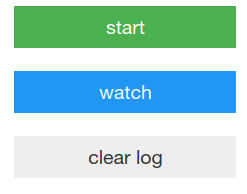

在加载数据的同时，您可以执行下面这个单元格，体验加载过程中数据量的实时变化。

,123countInteger
1,100000000

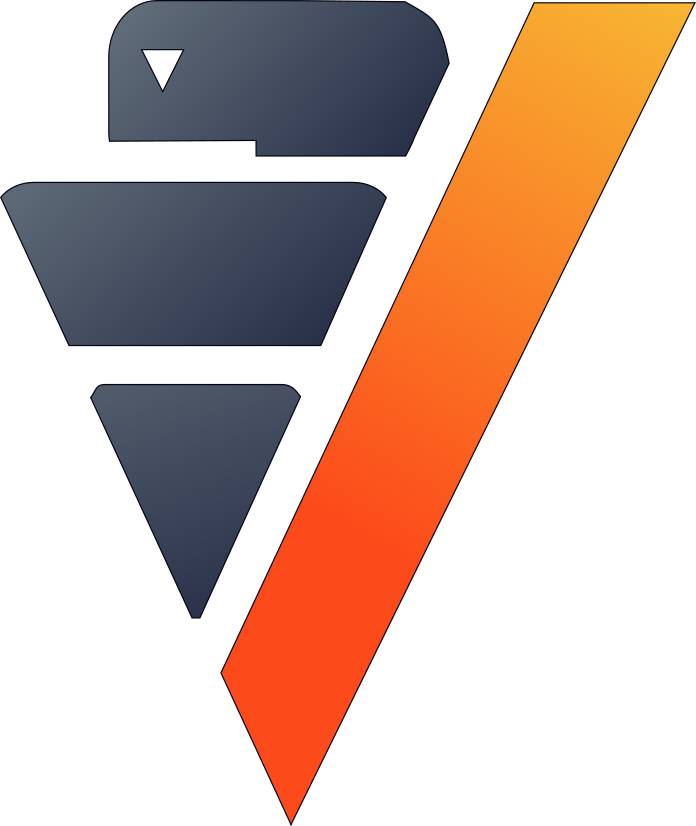

In [10]:
%sql select count(*) from events;

下面可以看到，JSON 格式的数据实际上被 Vertica 解析后存放到名为 `__raw__` 的大二进制列中。我们可以直接用 JSON 中的属性名(Vertica 称之为虚拟列)来进行查询，由此可见弹性表的灵活性，内容有差别的事件信息都可以直接存放在一起。

,AbctimeLong varchar(32000000),Abcdevice_idLong varchar(32000000),AbcLong varchar(32000000)
1,2022-03-27 08:46:49.604250,1,
2,2022-03-27 08:46:49.604250,2,
3,2022-03-27 08:56:04.242867,1,

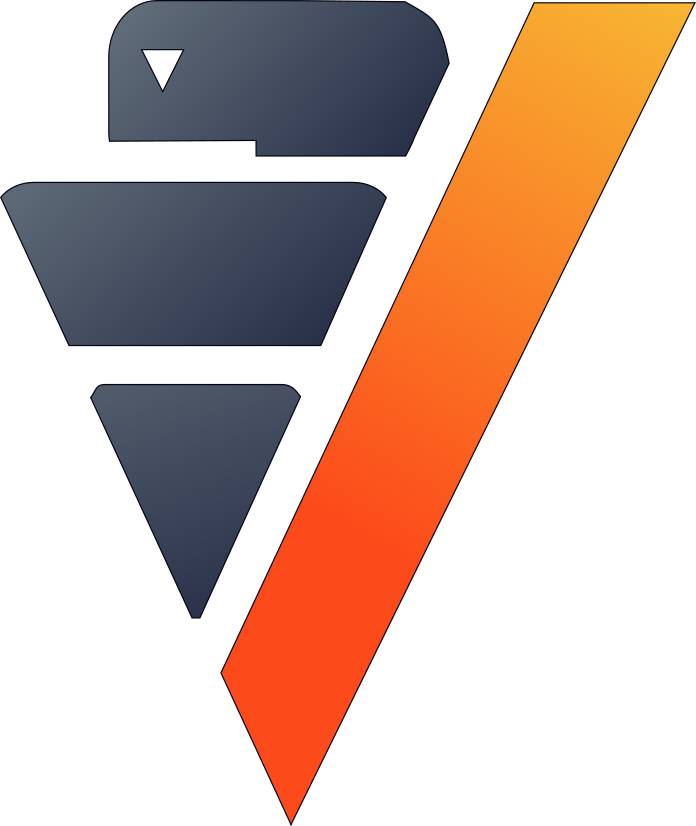

In [11]:
%sql select time, device_id, maptostring(__raw__) from events limit 3

## 3. 为实时分析而优化存储

我们经常需要对数据进行去重、聚合等查询。实时分析的特点是没有像传统批量数据仓库那样有较长的时间窗口来对数据进行深度汇总等加工，因此需要分析数据自己为分析查询提供丰富的存储优化手段。

### 3.1 去重

弹性表把 JSON 或其他格式的半结构化数据解析为 MAP 格式并存储在一个名为 `__raw__` 的大二进制列中，所以它能加载没有严格模式的数据。在查询的时候，数据库优化器自动把查询中用到的列改写为从 MAP 中用函数去查找。
例如：

```sql
select count(distinct device_id::int), max(value1::float) from events;
```

在执行的时候会被改写为


```sql
select count(distinct MapLookup(events.__raw__, 'device_id')::int), max(MapLookup(events.__raw__, 'value1')::float) from events;
```

#### 3.1.1 优化前

对 device_id 去重计数，同时计算指标 value1 的最大值。

,123countInteger,123maxFloat
1,10000,104.9067

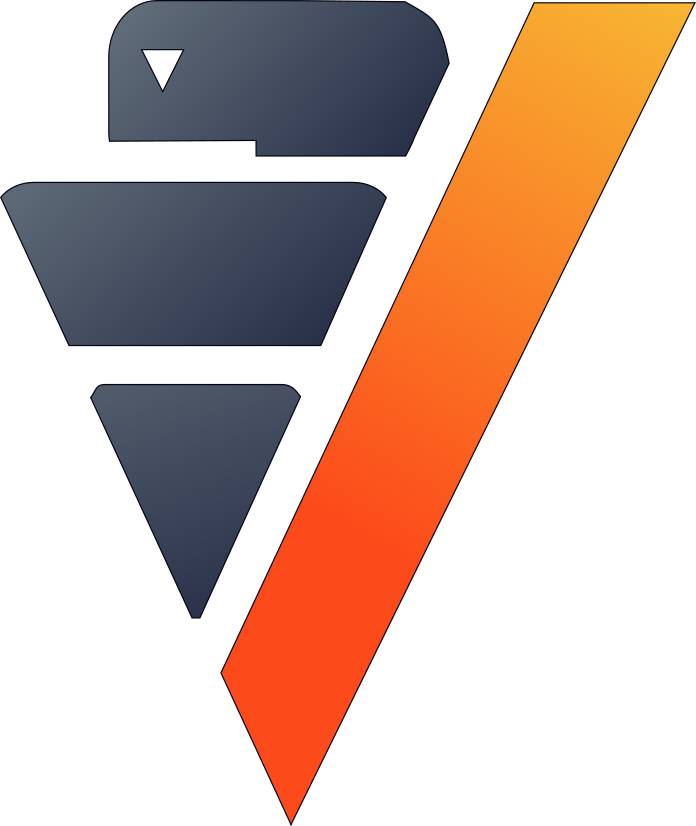

In [12]:
%sql select count(distinct device_id::int), max(value1::float) from events;


#### 3.1.2 优化方法1：把常用的虚拟列添加为物理的列

表的物理列可以用来分布数据、排序和压缩，查询性能通常要比弹性表的虚拟列快1~2个数量级以上。而且如果弹性表中有与虚拟列名称相同的物理列，Vertica在加载数据时会自动给物理列赋值，省去了手工维护它们一致性的步骤。因此把虚拟列物化是优化弹性表查询性能的常用方法。

下面的步骤把常用的列添加到弹性表中。一开始给新列加上缺省值表达式，目的是从已经存在的数据中给新加的列赋上正确的值。一旦列添加上后，就不再需要这个缺省值属性了，所以再把它删除掉。

In [13]:
%%sql

alter table events 
  add column if not exists device_id int 
  default maplookup(events.__raw__, 'device_id')::int encoding RLE;
alter table events alter column device_id drop default;

alter table events 
  add column if not exists "time" timestamp 
  default maplookup(events.__raw__, 'time')::timestamp;
alter table events alter column "time" drop default;

alter table events 
  add column if not exists "value1" float 
  default maplookup(events.__raw__, 'value1')::float;
alter table events alter column "value1" drop default;

ALTER
ALTER
ALTER
ALTER
ALTER
ALTER


再试一下在新加的物理列上执行这个查询的性能，通常能得到1~2个量级的提升。

,123countInteger,123maxFloat
1,10000,104.9067

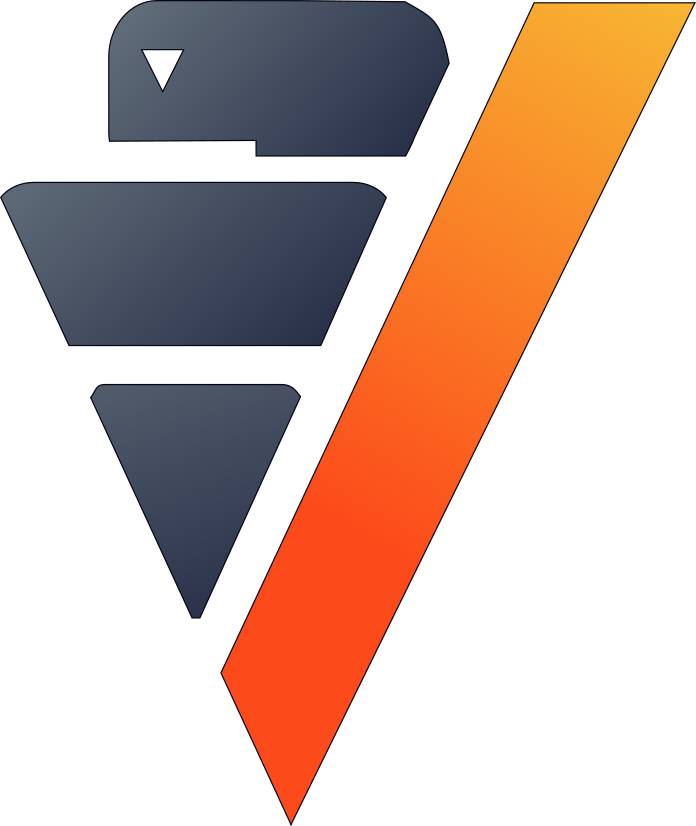

In [14]:
%sql select count(distinct device_id::int), max(value1::float) from events;

上面是为了方便直观理解，我们用手工方式创建物化的列。其实 Vertica 还提供了 COMPUTE_FLEXTABLE_KEYS、COMPUTE_FLEXTABLE_KEYS_AND_BUILD_VIEW 和 MATERIALIZE_FLEXTABLE_COLUMNS 三个函数帮助我们根据数自动猜测每个列的数据类型、创建带列名称的视图、以及物化常用列，详见 [Materializing FlexTables](https://www.vertica.com/docs/latest/HTML/Content/Authoring/FlexTables/MaterializingFlexTables.htm)。

#### 3.1.2 优化方法2：创建聚合 Projection

实时聚合的 Projection (Vertica 称为 [LAP, Live Aggregate Projections](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/AggregatedData/LiveAggregateProjections.htm)) 自动保存实时数据的聚合结果，通常可以减少查询时实际要扫描的数据量，从而大幅提升查询性能。

In [15]:
%%sql
create projection if not exists events_grp_device_id_max_value1 (
    device_id encoding RLE,
    max_value1
)
as 
select device_id,
  max(value1) as max_value1
from events
group by device_id;

select refresh('events');

CREATE
Refresh completed with the following outcomes:
Projection Name: [Anchor Table] [Status] [Refresh Method] [Error Count] [Duration (sec)]
----------------------------------------------------------------------------------------
"public"."events_grp_device_id_max_value1": [events] [refreshed] [scratch] [0] [5]



再次执行查询，优化后的性能通常可以再提升2个量级。

,123countInteger,123maxFloat
1,10000,104.9067

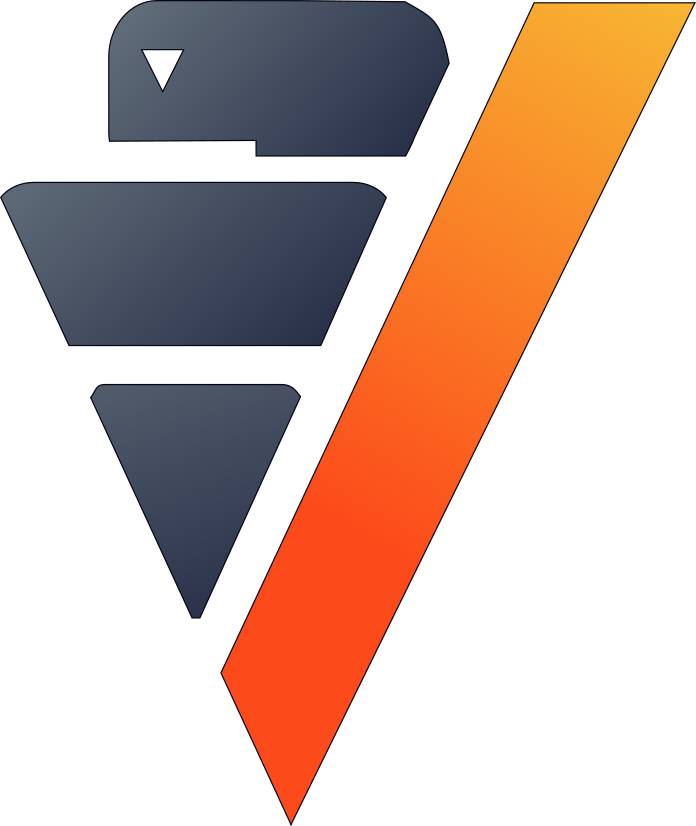

In [16]:
%sql select count(distinct device_id), max(value1) from events;

### 3.2 不同时间粒度的聚合

传感器或埋点数据一般就是时间序列。我们在分析的时候不仅仅看精确的时点数据，有时候也要看指标在分钟、10分钟、小时、天等不同粒度的时间上的统计结果。

#### 3.2.1 优化前

例如，像下面这样按分钟来聚合指标。

,📅timeDatetime,123value1Float,123value2Float
1,2022-03-27 08:43:00,-29.1907617647059,[null]
2,2022-03-27 08:44:00,-10.941435,[null]
3,2022-03-27 08:45:00,10.166580952381,[null]
4,2022-03-27 08:46:00,30.3930023809524,[null]
5,2022-03-27 08:47:00,47.7376952380952,[null]
6,2022-03-27 08:48:00,62.4975523809524,[null]
7,2022-03-27 08:49:00,73.4600707317073,[null]
8,2022-03-27 08:50:00,81.5694047619048,[null]
9,2022-03-27 08:51:00,87.6718952380952,[null]
10,2022-03-27 08:52:00,91.6336571428571,[null]

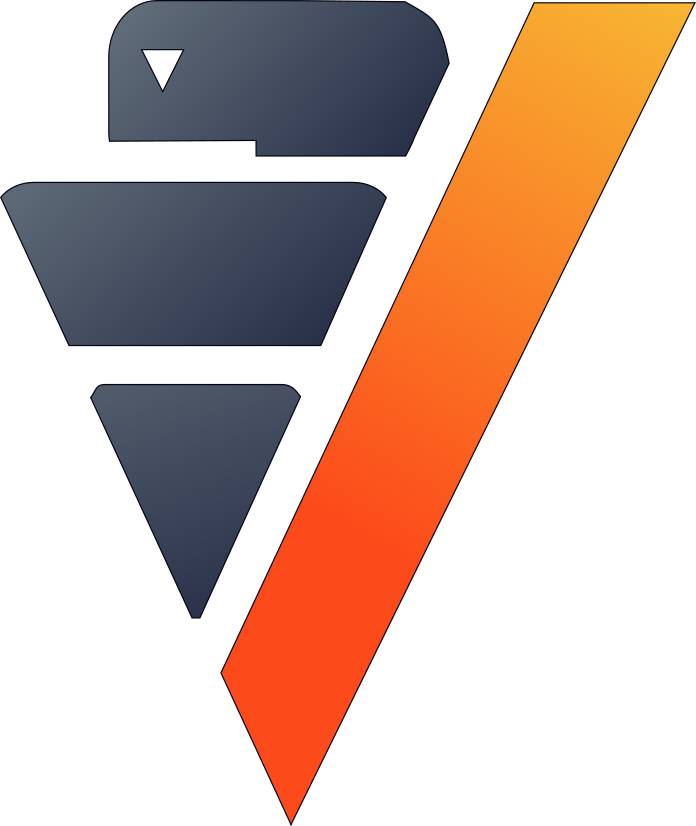

In [17]:
%%sql
select trunc(time, 'MI') as time
  , avg(value1::float) as value1 
  , avg(value2::float) as value2 
from events
where device_id = 0
group by 1
order by 1
;

#### 3.2.2 创建聚合 projection 来优化性能

如果这个查询用在实时大屏幕或看板上，我们希望这个能查询执行得更快一些，最好在亚秒级。按照聚合时间粒度和其他维度来创建聚合的 Projection，可以帮我们实现这个目标。 

注意，Vertica 在聚合计算 AVG 的时候，实际上是按 SUM_FLOAT/COUNT 来计算的。

In [18]:
%%sql
create projection if not exists events_grp_device_id_time_mi (
    device_id encoding RLE
    , time_mi
    , value1_count
    , value1_sum
    , value2_count
    , value2_sum
)
as 
select device_id
  , trunc(time, 'MI') as time_mi
  , count(value1::float) as value1_count
  , sum_float(value1::float) as value1_sum
  , count(value2::float) as value2_count
  , sum_float(value2::float) as value2_sum
from events
group by device_id
  , trunc(time, 'MI')
;

select refresh('events');

CREATE
Refresh completed with the following outcomes:
Projection Name: [Anchor Table] [Status] [Refresh Method] [Error Count] [Duration (sec)]
----------------------------------------------------------------------------------------
"public"."events_grp_device_id_time_mi": [events] [refreshed] [scratch] [0] [194]



在这个聚合 Projection 上执行功能相同的查询，通常可以观察到2个量级的性能提升。

,📅timeDatetime,123value1Float,123value2Float
1,2022-03-27 08:43:00,-29.0747117647059,-15.3159441176471
2,2022-03-27 08:44:00,-10.75996,-5.3710125
3,2022-03-27 08:45:00,10.3071619047619,5.14524047619048
4,2022-03-27 08:46:00,30.1671095238095,15.4347119047619
5,2022-03-27 08:47:00,48.2652166666667,25.8328571428571
6,2022-03-27 08:48:00,62.2291261904762,35.7548166666667
7,2022-03-27 08:49:00,73.3635658536585,45.322456097561
8,2022-03-27 08:50:00,81.9107690476191,54.4237666666667
9,2022-03-27 08:51:00,87.2705,62.885330952381
10,2022-03-27 08:52:00,91.6037476190476,70.670130952381

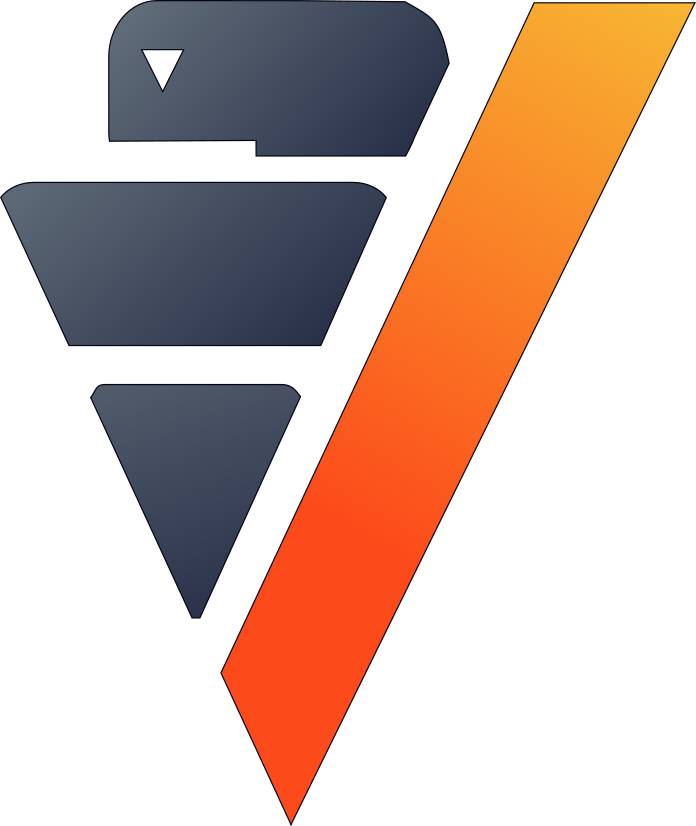

In [19]:
%%sql
select trunc(time, 'MI') as time
  , avg(value1::float) as value1 
  , avg(value2::float) as value2 
from events
where device_id = 0
group by 1
order by 1
;

根据优化后的效果，我们可以快速看看按分钟聚合的指标曲线。

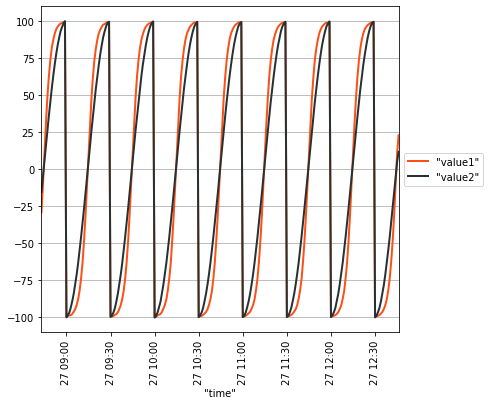

In [20]:
from verticapy import vdf_from_relation

vdf_from_relation("""(
select trunc(time, 'MI') as time
  , ifnull(avg(value1::float), 0) as value1 
  , ifnull(avg(value2::float), 0) as value2
from events 
where device_id = 1
group by 1
order by 1
) x""").plot(ts = "time", columns = ["value1", "value2"])

### 3.3 取最新数据

监控生产过程和异常，有时候我们只需要最新的几个数据点。这时如果每次查询都按时间扫描出最后几个数据点，就比较耗费时间。

#### 3.2.1 优化前

例如，只取最新的3个数据指标：

,123device_idInteger,📅timeDatetime,123valueFloat
1,0,2022-03-27 12:46:14.919596,24.9890666666667
2,1,2022-03-27 12:46:14.919596,24.1385666666667
3,2,2022-03-27 12:46:14.919596,25.2174
4,3,2022-03-27 12:46:14.919596,25.244
5,4,2022-03-27 12:46:14.919596,25.3334666666667
6,5,2022-03-27 12:46:14.919596,23.8856666666667
7,6,2022-03-27 12:46:14.919596,23.8675333333333
8,7,2022-03-27 12:46:14.919596,24.3220666666667
9,8,2022-03-27 12:46:14.919596,25.1300333333333
10,9,2022-03-27 12:46:14.919596,25.3739666666667

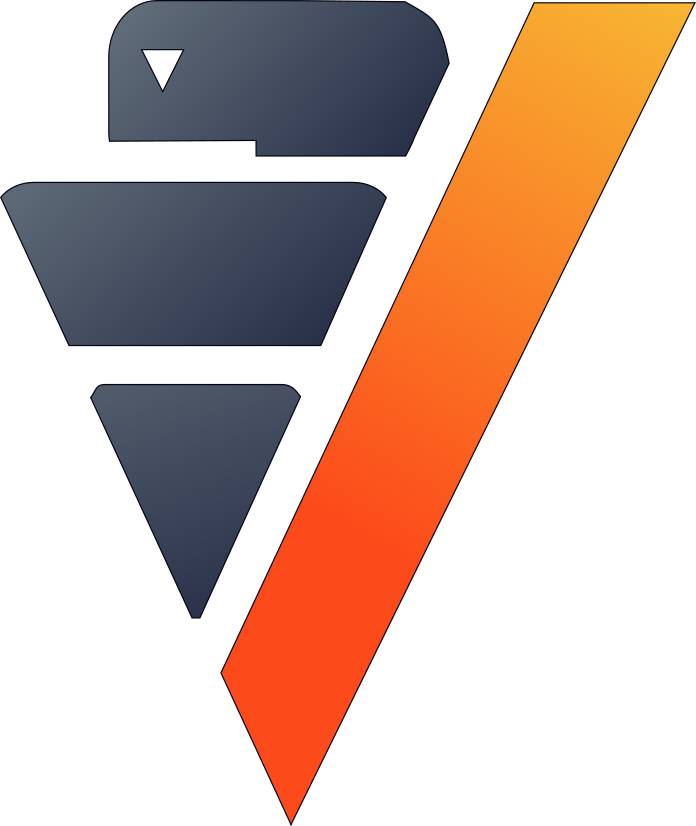

In [21]:
%%sql
select device_id, max(time) as time, avg(value1) as value from (
    select device_id, time, value1 from events
    limit 3 over(partition by device_id order by time desc) 
) t 
group by 1;

#### 3.3.2 创建 TopK Projection

Vertica 的 [TopK Projections](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/AggregatedData/TopKQueryProjections.htm) 只存储根据实时数据自动更新的 K 条数据，因此能大幅减少查询时要扫描的数据量，从而提升性能。

In [22]:
%%sql
create projection if not exists events_top3_device_id_time_value1 (
    device_id encoding RLE
    , time
    , value1
)
as 
select device_id
  , time
  , value1
from events
limit 3 over(partition by device_id order by time desc)
;

select refresh('events');

CREATE
Refresh completed with the following outcomes:
Projection Name: [Anchor Table] [Status] [Refresh Method] [Error Count] [Duration (sec)]
----------------------------------------------------------------------------------------
"public"."events_top3_device_id_time_value1": [events] [refreshed] [scratch] [0] [4]



再次执行，这里通常也可以观察到2个量级的性能提升。

,123device_idInteger,📅timeDatetime,123valueFloat
1,0,2022-03-27 12:46:14.919596,24.9890666666667
2,1,2022-03-27 12:46:14.919596,24.1385666666667
3,2,2022-03-27 12:46:14.919596,25.2174
4,3,2022-03-27 12:46:14.919596,25.244
5,4,2022-03-27 12:46:14.919596,25.3334666666667
6,5,2022-03-27 12:46:14.919596,23.8856666666667
7,6,2022-03-27 12:46:14.919596,23.8675333333333
8,7,2022-03-27 12:46:14.919596,24.3220666666667
9,8,2022-03-27 12:46:14.919596,25.1300333333333
10,9,2022-03-27 12:46:14.919596,25.3739666666667

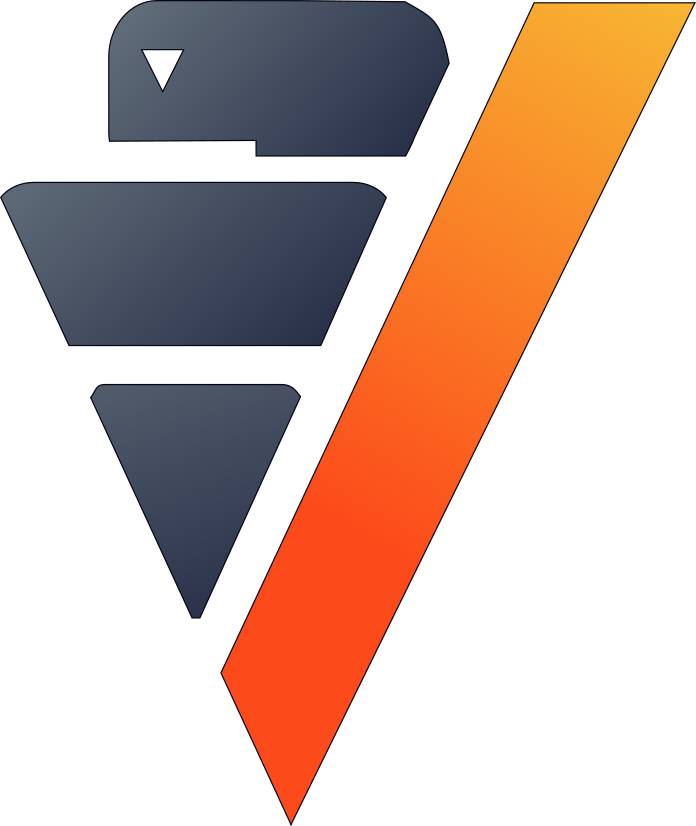

In [23]:
%%sql
select device_id, max(time) as time, avg(value1) as value from (
    select device_id, time, value1 from events
    limit 3 over(partition by device_id order by time desc) 
) t 
group by 1;

## 4. 机器学习

Vertica 能实时地加载数据，也提供了极速的分析查询能力。其实 Vertica 还内置了丰富的数据准备和机器学习算法，用 SQL 就可以快速地进行模型训练、测试、评估和预测分析。

我们先观察一下 device_id = 1 的指标时间序列的曲线。

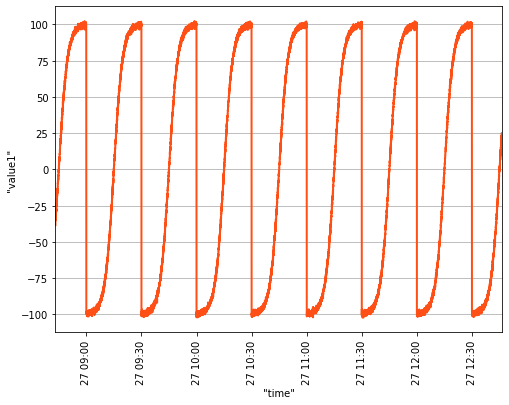

In [24]:
from verticapy import vdf_from_relation

vdf_from_relation("""(
select time
  , value1 
from events
where device_id = 1
order by 1
) x""").plot(ts = "time", columns = ["value1"], step = True)

这个曲线有明显跳跃的地方。我们先按跳变的地方分割成不同的独立行为序列，即会话化([Sessionization](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/SQLAnalytics/SessionizationWithEvent-basedWindows.htm))。

### 4.1 通过会话化事件获取独立的序列

首先取平均的相邻点指标变化，并以此作为划分不同的时间序列的依据。

In [25]:
df = %sql select avg(abs(step)) as step from ( \
    select value1 - lag(value1) over(order by time) as step \
    from events \
    where device_id = 1) t;

step = df["step"][0]

窗口函数 [CONDITIONAL_TRUE_EVENT](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/SQLAnalytics/SessionizationWithEvent-basedWindows.htm) 可以根据相邻事件的指标变化是否明显而把事件划分成模式不同的独立会话。

这里我们取最后的一个会话作为分析的序列。

In [26]:
df = %sql \
with ts (time, value1) as ( \
    select time, value1 \
    from events \
    where device_id = 1) \
select min(time) \
from ( \
    select time, value1 \
        , CONDITIONAL_TRUE_EVENT(abs(value1 - lag(value1)) > 10 * {step} ) \
        over(order by time desc) as session \
    from ts \
) t \
where session = 0 \
order by 1 ;

dtBegin = df["min"][0]

取出最后一个序列的开始时间点后，再看一下这个序列的样子。

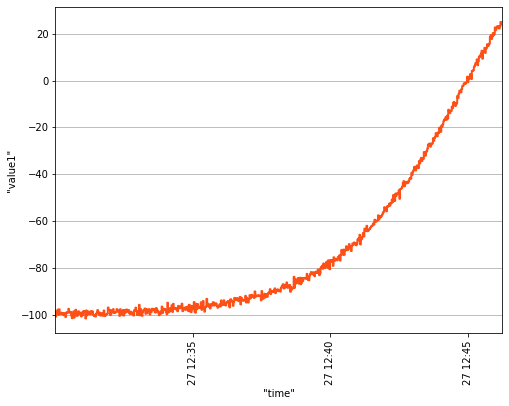

In [27]:
from verticapy import vdf_from_relation

df = vdf_from_relation(f"""(
select time
  , value1 
from events
where device_id = 1
  and time >= '{dtBegin}'
order by 1
) x""").plot(ts = "time", columns = ["value1"], step = True)

下面我们用序列的自关联模型([Autoregressive Model](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/MachineLearning/TimeSeries/AutoregressorExample.htm))来进行模型训练、测试和预测。

### 4.2 数据准备和训练模型

自关联模要求时间步长相同，因此首先需要按相同步长对数据进行插补([Gap Filling and Interpolation](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/TimeSeries/GapFillingAndInterpolationGFI.htm))。

#### 4.2.1 数据准备

Vertica 内置时间序列处理先关的功能。数据插补非常简单，使用 TIMESERIES 语法和 TS_FIRST_VALUE 或 TS_LAST_VALUE 函数就能轻松完成数据准备，结果是一个视图。

In [28]:
# linear Interpolation with 2 seconds steps here
%sql \
create or replace view events_device_1 as \
with ts(time, device_id, value1) as ( \
    select time \
        , device_id \
        , value1 \
        from events \
        where device_id = 1 \
            and time >= '{dtBegin}' \
) \
select time_slice as time \
    , device_id \
    , value1 \
from ( \
    select time_slice \
        , device_id \
        , TS_FIRST_VALUE(value1, 'LINEAR') as value1 \
    from ts \
    TIMESERIES time_slice AS '2 seconds' \
      OVER(PARTITION BY device_id ORDER BY time) \
) t;

CREATE


#### 4.2.2 模型训练

我们把最后几个时间步保留用来稍后做测试，其他的数据用于训练模型。
Vertica 把训练模型和模型管理都实现为 SQL 函数 或语句的形式，用 SQL 执行非常方便。

In [29]:
# get the last step
df = %sql select max(time) from events_device_1;
maxTime = df["max"][0]

# hold out the latest 10 steps for testing, train model with steps before
%sql \
create or replace view events_device_1_train as \
select time \
  , value1 \
from events_device_1 \
where time <= (timestamp '{maxTime}' - 10 * interval '2 seconds') ;

# train model
%sql drop model if exists ar_events_device_1;

%sql select AUTOREGRESSOR('ar_events_device_1', \
                     'events_device_1_train', 'value1', 'time' \
                          using parameters p=3);
# show model
df = %sql \
select GET_MODEL_SUMMARY(using parameters model_name='ar_events_device_1');

print(df["GET_MODEL_SUMMARY"][0])

CREATE


DROP


Finished. 477 elements accepted, 1 elements rejected.





coefficients
parameter| value  
---------+--------
  alpha  | 1.46318
phi_(t-1)| 0.41600
phi_(t-2)| 0.31114
phi_(t-3)| 0.28652


mean_squared_error
not evaluated

timeseries_name
value1

timestamp_name
time

call_string
autoregressor('public.ar_events_device_1', 'events_device_1_train', 'value1', 'time'
USING PARAMETERS p=3, missing=linear_interpolation, regularization='none', lambda=1, compute_mse=false);

Additional Info
       Name       | Value  
------------------+--------
    lag_order     |   3    
      lambda      | 1.00000
rejected_row_count|   1    
accepted_row_count|  477   



### 4.3 测试和预测未来

有了训练好的模型，对未来时间点的指标预测就容易了。

我们在同一张图上绘制出实际发生的指标曲线、与最后10个时间点模型预测结果的对比，以及未来10个时间点的预测指标。

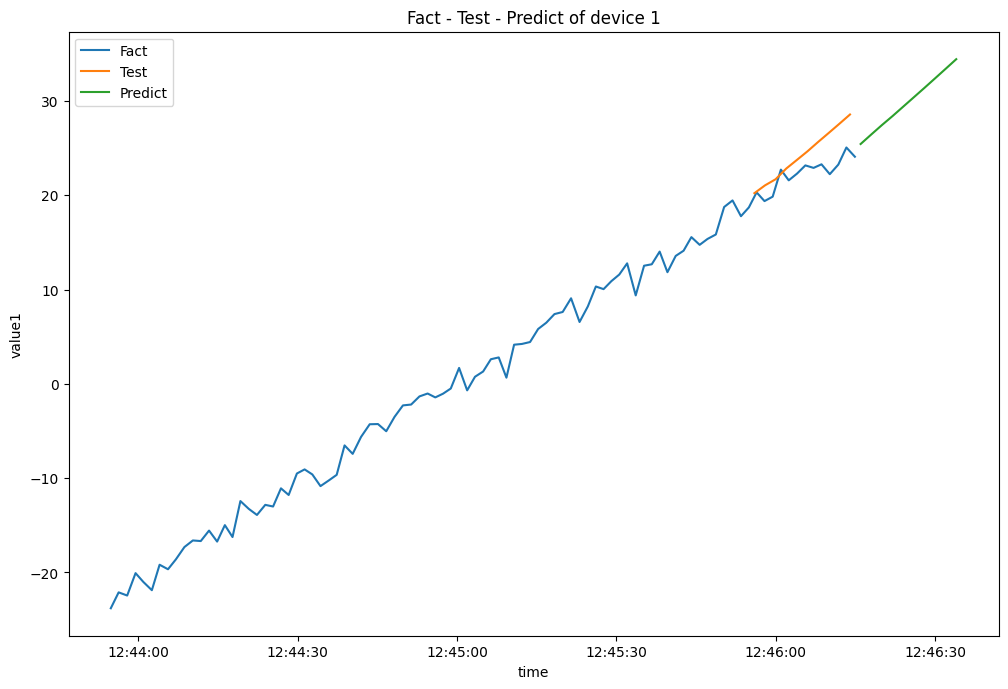

In [30]:
# get the last step
df = %sql select max(time) from events_device_1;
maxTime = df["max"][0]

from datetime import timedelta

# the latest 10 steps for testing
timeTest = [ maxTime + timedelta(seconds=2*(1+i)) for i in range(-10, 0)]

dfTest = %sql \
select PREDICT_AUTOREGRESSOR(value1 \
    using parameters model_name='ar_events_device_1', npredictions=10) \
        over(ORDER BY time) as value1 \
from events_device_1 \
where time <= (timestamp '{maxTime}' - 10 * interval '2 seconds') \
    and time > (timestamp '{maxTime}' - (10 + 3) * interval '2 seconds') ;

# the comming 10 steps for prediction
timePredict = [ maxTime + timedelta(seconds=2*(1+i)) for i in range(10)]

dfPredict = %sql \
select PREDICT_AUTOREGRESSOR(value1 \
    using parameters model_name='ar_events_device_1', npredictions=10) \
        over(ORDER BY time) as value1 \
from events_device_1 \
where time <= timestamp '{maxTime}' \
    and time > (timestamp '{maxTime}' - 3 * interval '2 seconds') ;

dfFact = %sql \
select time, value1 \
from events \
where device_id = 1 \
    and time > (timestamp '{maxTime}' - 70 * interval '2 seconds') \
order by time;


# show fact and test & predict result in same picture
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8), dpi= 100)

plt.plot(dfFact.to_numpy()[:, 0], dfFact.to_numpy()[:, 1], label='Fact')
plt.plot(timeTest, dfTest.to_numpy()[:, 0], label='Test')
plt.plot(timePredict, dfPredict.to_numpy()[:, 0], label='Predict')

plt.xlabel('time')
plt.ylabel('value1')

plt.title('Fact - Test - Predict of device 1')
plt.legend()
plt.show()

可以看到，最后10个时间点的模型预测值与实际值比较接近且趋势一致。

## 5. 总结

上面我们只是展示了 JSON 半结构化数据的准实时加载、分析查询和用库内机器学习进行模型训练和预测分析。事实上它们同样适用于结构化数据和普通表。

不只是这些！

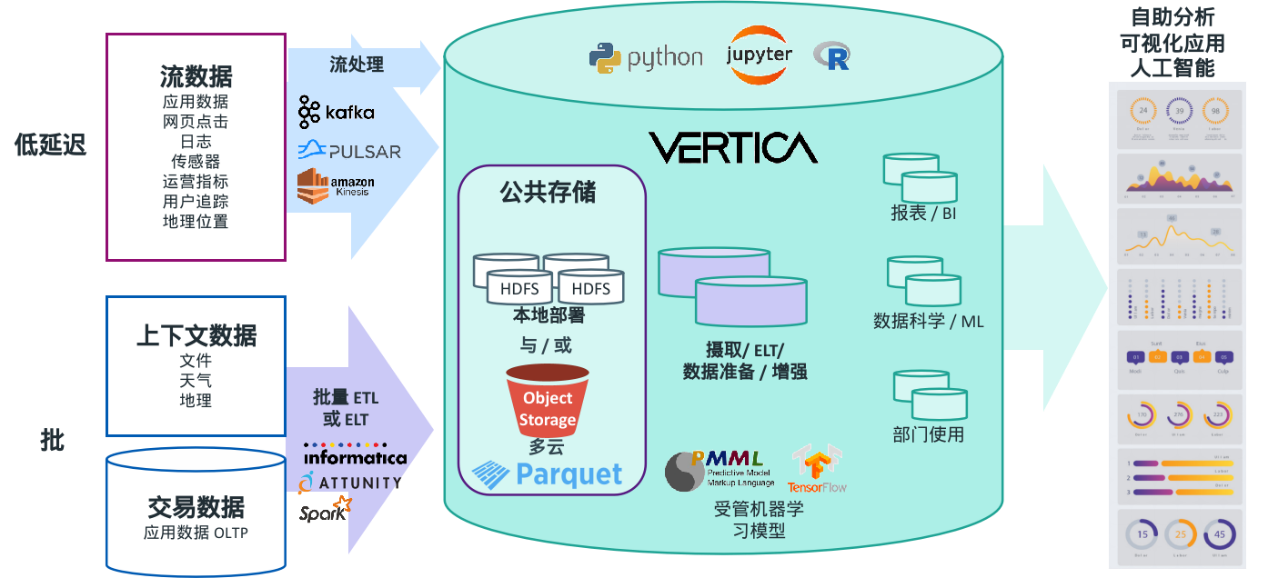

Vertica 可以与 Informatica、Attunity、Kettle 等 ETL 工具集成，内置 Kafka 流式引擎的连接器，与 Spark 双向无缝集成，实现数据的准实时或大批量的数据整合和处理，并欢迎各种 BI 和可视化工具，如Tableau、Qlik、MicroStrategy 等。 Vertica 以开放的架构支持客户所需的各种平台，并且支持就地分析存储在 HDFS 或 S3 对象存储数据湖中的 Parquet 或 ORC 等开放数据格式，从而形成一个大数据的统一分析仓库，整合历史和最新的结构化和半结构化的、分布在企业各处数据孤岛中的所有数据，为企业提供全面的数据和完整的企业级关系模型，在内置的机器学习和纳入管理的 PMML 或 TensorFlow 的支持下提供准实时的预测分析能力，支撑企业的业务数字化转型和数据驱动业务快速创新。